In [1]:
import torch

from matplotlib import pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from datasets.embeddings_and_relations_dataset import EmbeddingsAndRelationsDataset
from models.re_bert_crf import ReBertCrf
from re_utils.train import dict_to_device

from IPython import display

In [2]:
num_re_tags = 12
batch_size = 16
hidden_size = 768
dropout = 0.2
entity_tag_to_id_path = "resources/data/train/entity_tag_to_id.json"
relation_training_data_path = "resources/data/train/relation_training_data.jsonl"
lr = 1e-3
epochs = 5
device = "cuda" if torch.cuda.is_available() else "cpu"

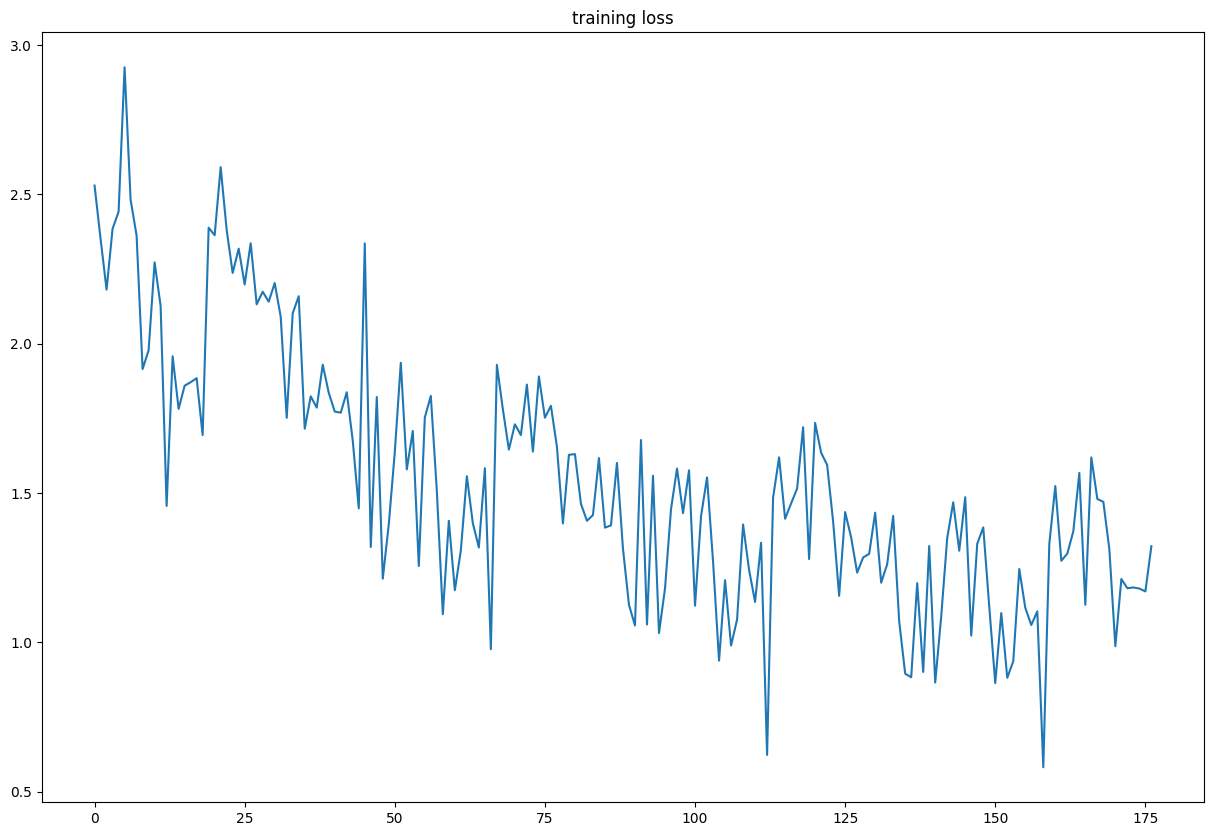

Current loss: 1.3220915794372559
torch.Size([179776, 12])
tensor([  11,   11,   11,  ..., -100, -100, -100], device='cuda:0')


In [ ]:
model = ReBertCrf(
    num_re_tags=num_re_tags,
    hidden_size=hidden_size,
    dropout=dropout,
    entity_tag_to_id_path=entity_tag_to_id_path
)
model = model.to(device)
dataset = EmbeddingsAndRelationsDataset(relation_training_data_path=relation_training_data_path)

data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.collate_function)
criterion = CrossEntropyLoss(weight=torch.tensor([1/342, 1/2556, 1/458, 1/122, 1/1887, 1/576, 1/66, 1/408, 1/58, 1/275, 1/109, 1/3441847], device=device))

optimizer = Adam(model.parameters(), lr=lr)

loss_history = []

for epoch in range(1, epochs + 1):
    for batch in data_loader:
        optimizer.zero_grad()

        batch = dict_to_device(batch, device)
        relation_matrix_ground_truth = batch["relation_matrix"]
        del batch["relation_matrix"]

        logits = model(**batch)

        loss = criterion(logits.flatten(end_dim=2), relation_matrix_ground_truth.flatten())
        loss.backward()

        loss_history.append(loss.item())

        optimizer.step()

        display.clear_output(wait=True)

        f, ax = plt.subplots()
        f.set_figwidth(15)
        f.set_figheight(10)

        ax.set_title("training loss")

        ax.plot(loss_history)

        plt.show()

        if len(loss_history) > 0:
            print(f"Current loss: {loss_history[-1]}")